# Calibration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from radar.data import load
from radar.processing import signal_intensity
from scipy.signal import detrend

import matplotlib
matplotlib.rc('font', size=16)

## Calibration parameters

### Ball

The radar was pointed at a steel ball that moved back and forth at an approximately constant speed.
I measured the travel time over the distance of 1 m for 10 revolutions.
I calculate the ball speed by averaging the measured times and by dividing the travel distance by that time.

In [2]:
ball_distance = 1 # m
ball_times = np.array([6.36, 6.48, 6.50, 6.48, 6.44, 6.42, 6.54, 6.42, 6.46, 6.41])
ball_speed = ball_distance / np.mean(ball_times) # m/s
ball_diameter = 0.014 # m
ball_radius = ball_diameter / 2
ball_circumference = ball_diameter * np.pi
ball_crosssection = ball_radius**2 * np.pi

In [3]:
ball_speed

0.1550147263990079

### Distance

In [4]:
calibration_length = 1.51 # distance between two wheels on the calibration rig [m]
diameter1 = 0.08 # diameter of wheel 1 [m]
diameter2 = 0.05 # diameter of wheel 2 [m]

In [5]:
revolution_distance = 2 * calibration_length + np.pi * (diameter1 + diameter2)

In [6]:
revolution_distance

3.428407044966673

### Geometry

Inclination angle:

$$
\theta_i = 18.4^\circ
$$

Height of radar head from target (calibration device):

$$
h = 0.57\ m
$$

Distance of radar head from target (center of the calibration device):

$$
d = h \cos{\theta_i}
$$

In [7]:
theta_i = np.deg2rad(18.4)
h = 0.57
d = h / np.sin(theta_i)
d # m

1.8058030701215873

### Radar properties

In [8]:
# these are values from the manual;
# confirm with John Mower that they're correct for the current system
wavelength_H = 0.0515 # m
wavelength_V = 0.0521 # m

In [9]:
ball_radius / wavelength_V

0.1343570057581574

In [10]:
ball_crosssection, ball_crosssection * 10**4 # m^2, cm^2

(0.0001539380400258999, 1.5393804002589988)

In [11]:
sigma_normalized = 2.9646 # based on Blake (1972)

In [12]:
sigma = sigma_normalized * ball_crosssection
sigma * 100 * 100 # cm^2

4.5636471346078284

In [13]:
path = 'data/calibration/20210709-180442.h5'

In [14]:
time, ref, Hpol, Vpol = load(path)

In [15]:
revolution_time = revolution_distance / ball_speed
correction_factor = 1.058

In [16]:
num_samples, num_records = ref.shape

In [17]:
dt = np.diff(time).mean()
time = np.linspace(time[0], time[-1] + dt, num_samples * num_records, endpoint=True)

In [18]:
revolutions = time / revolution_time * correction_factor

In [19]:
rho_h = signal_intensity(Hpol.real, Hpol.imag).flatten()
rho_v = signal_intensity(Vpol.real, Vpol.imag).flatten()
rho_ref = signal_intensity(ref.real, ref.imag).flatten()

rho_h_norm = rho_h / rho_ref
rho_v_norm = rho_v / rho_ref

## Signal intensity

$$
\rho = I^2 + Q^2
$$

where:

* $\rho$: Power
* $I$: In-phase signal (real component)
* $Q$: Quadrature signal (imaginary component)

Text(0.5, 0, 'Revolutions')

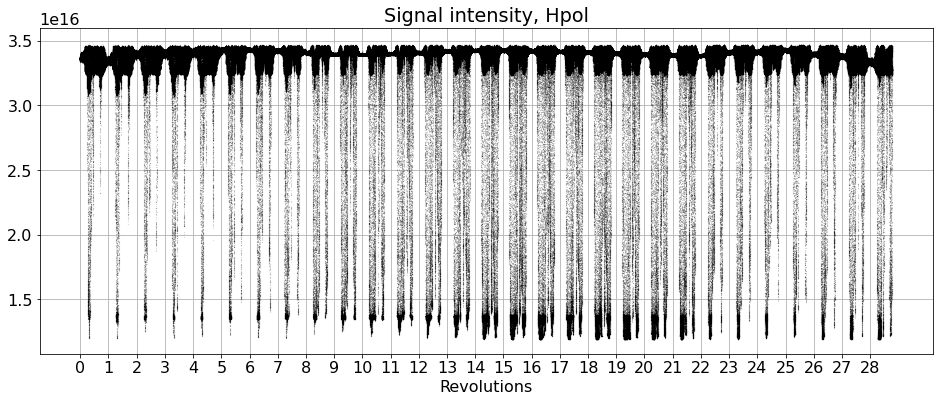

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_h, 'k.', ms=0.1)
plt.title('Signal intensity, Hpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

Text(0.5, 0, 'Revolutions')

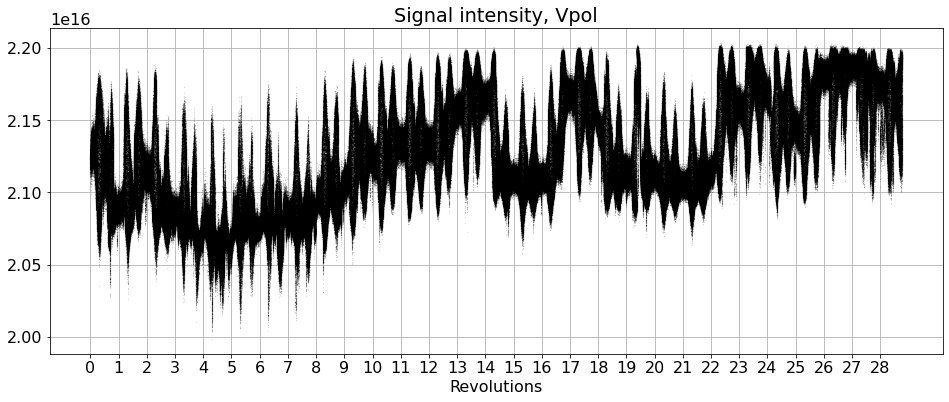

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_v, 'k.', ms=0.1)
plt.title('Signal intensity, Vpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

Text(0.5, 0, 'Revolutions')

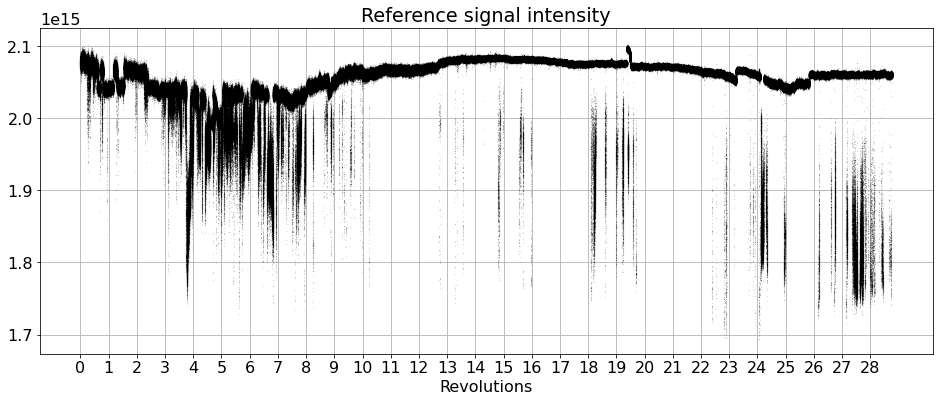

In [22]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_ref, 'k.', ms=0.1)
plt.title('Reference signal intensity')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

## Signal intensity, normalized by the reference signal

$$
\rho_{n} = (I^2 + Q^2) / R^2
$$

where:

* $R$: Reference signal

Text(0.5, 0, 'Revolutions')

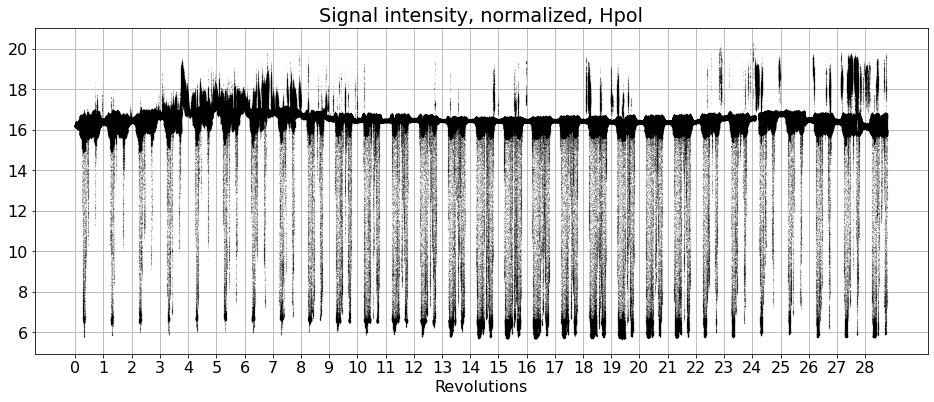

In [23]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_h / rho_ref, 'k.', ms=0.1)
plt.title('Signal intensity, normalized, Hpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

Text(0.5, 0, 'Revolutions')

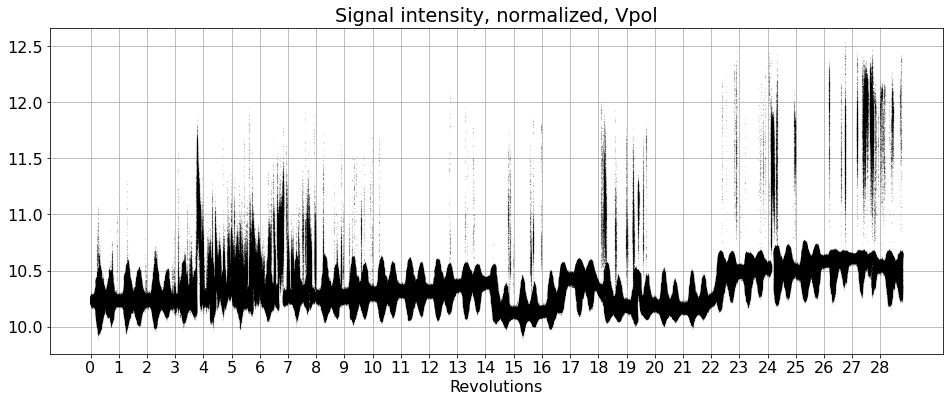

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_v / rho_ref, 'k.', ms=0.1)
plt.title('Signal intensity, normalized, Vpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

## Zoom in on one ball revolution

In [25]:
def running_mean(x, n):
    """Running mean with the window n."""
    return np.convolve(x, np.ones((n,)) / n, mode='same')

In [26]:
whole_revolutions = range(int(np.min(revolutions)), int(np.max(revolutions)))

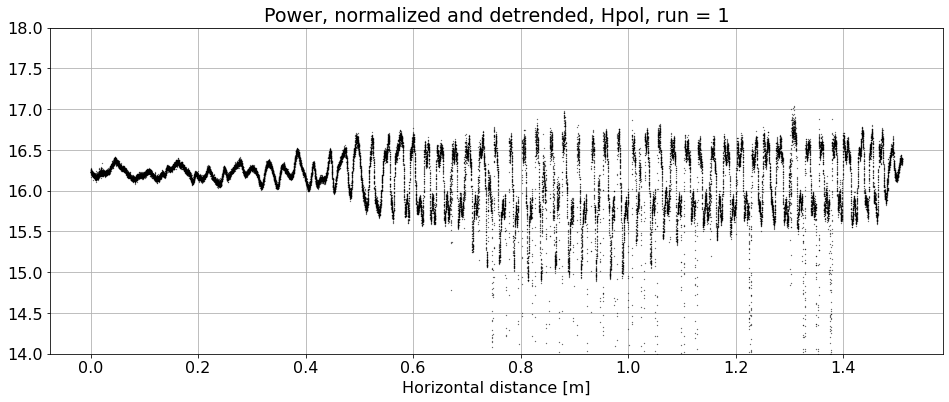

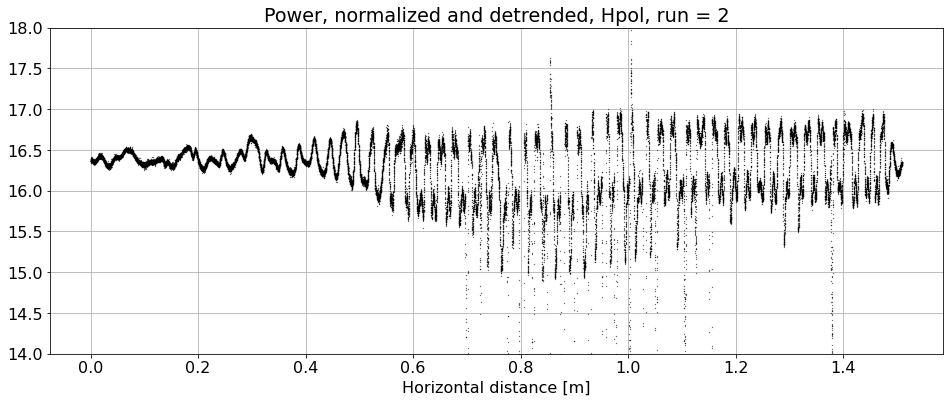

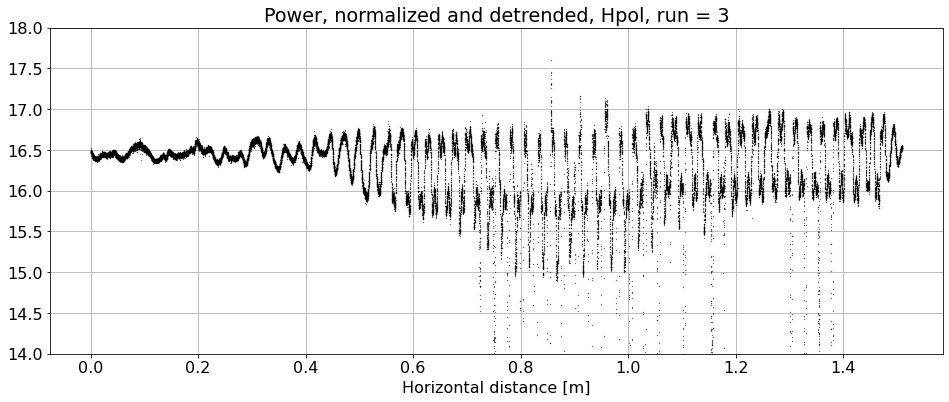

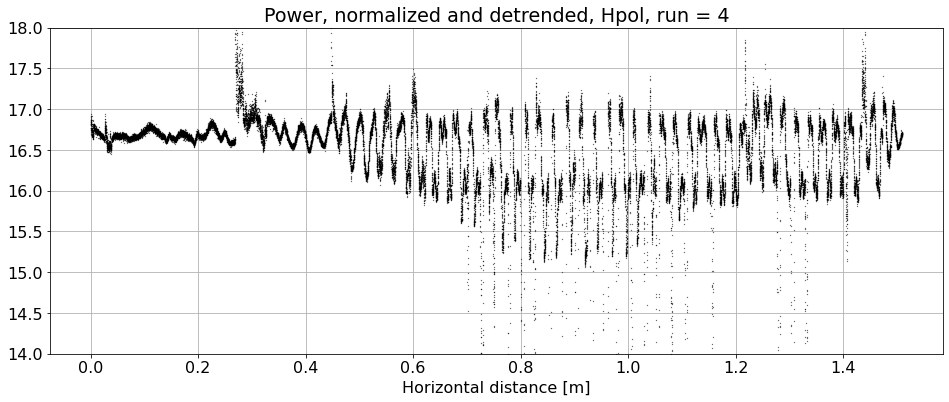

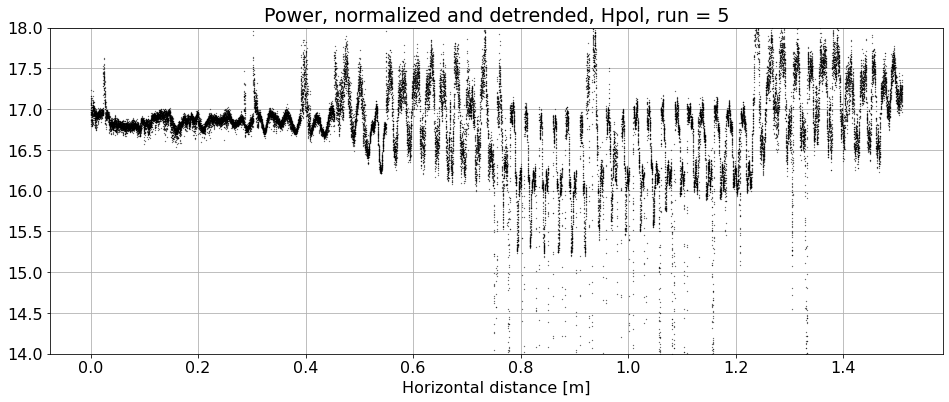

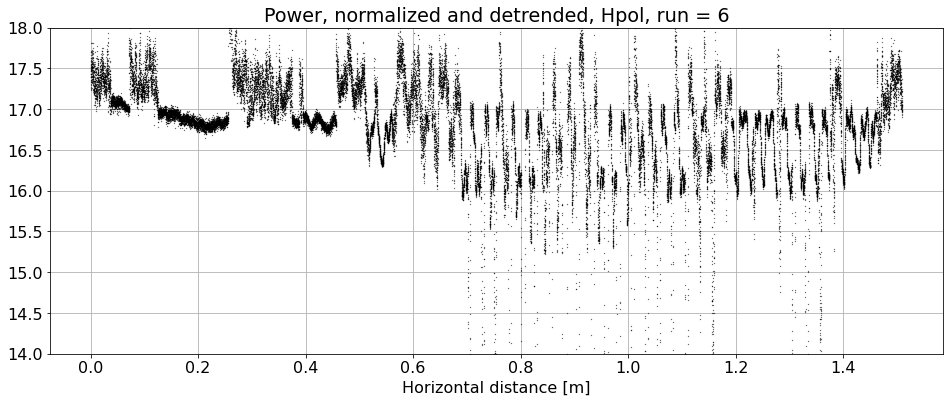

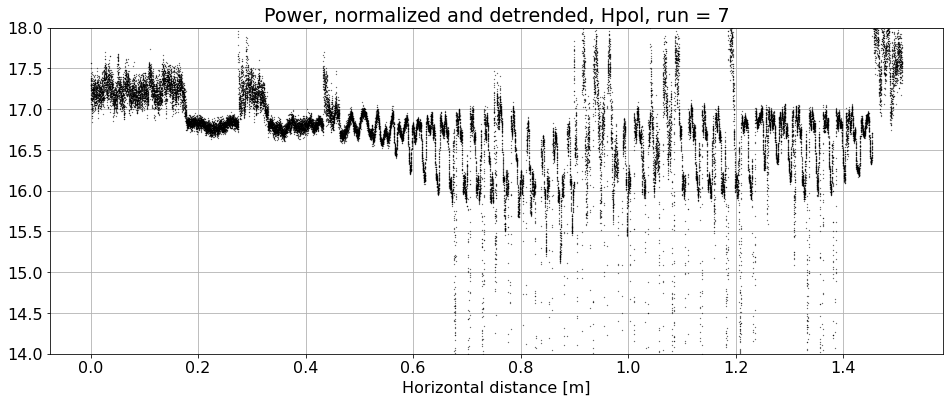

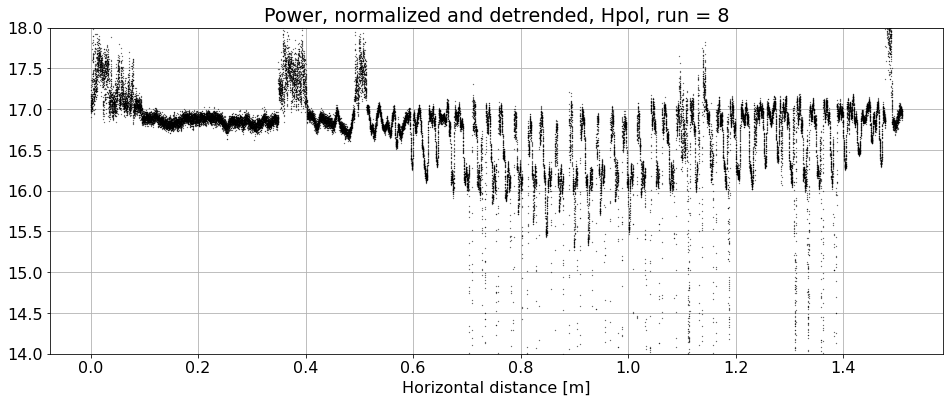

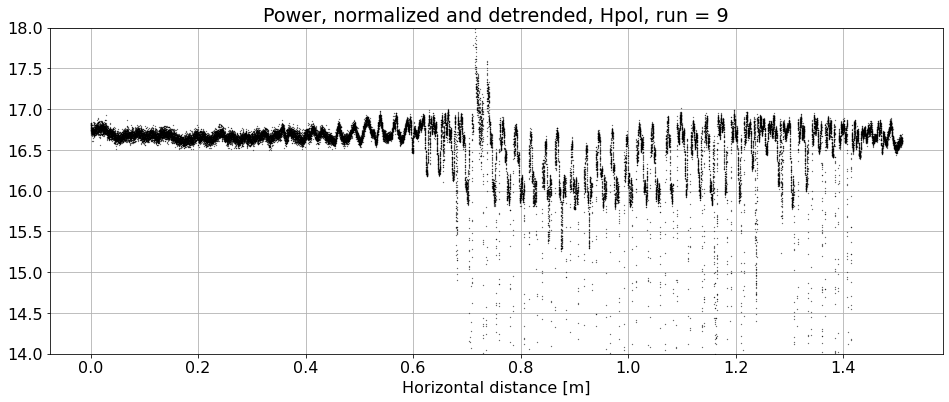

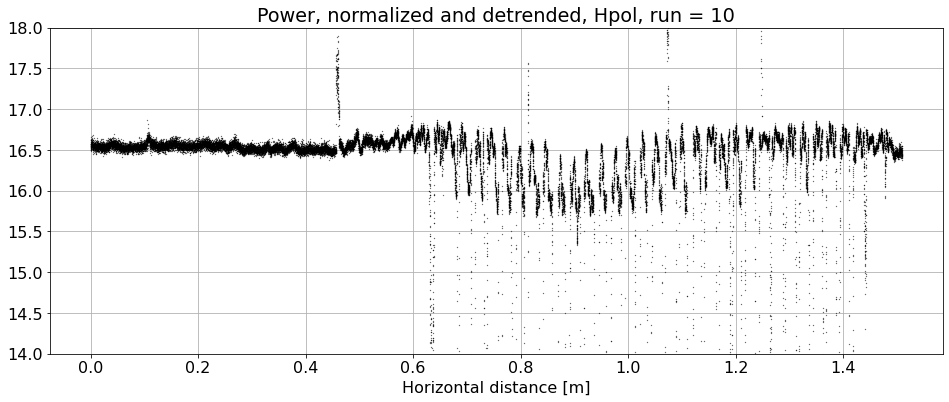

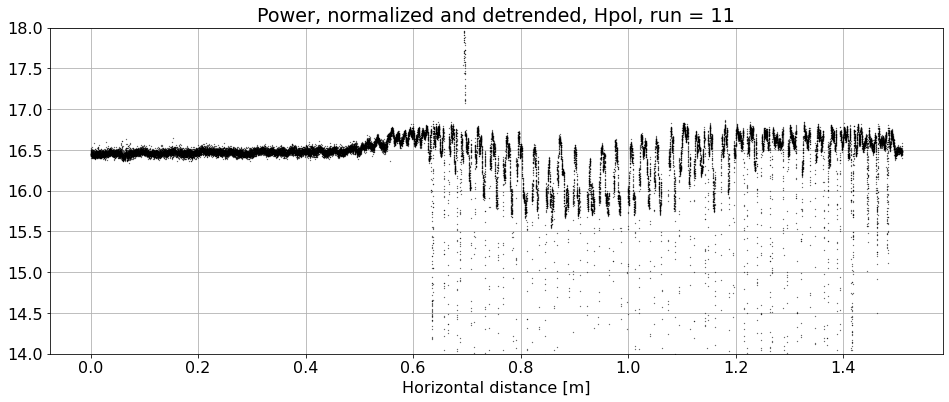

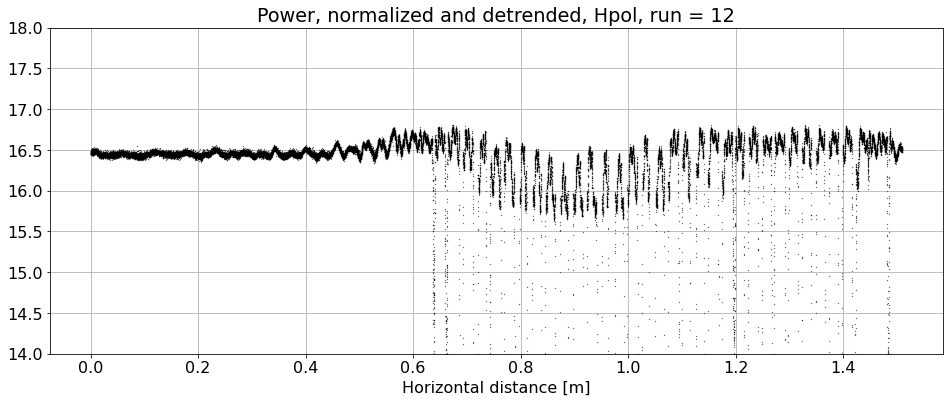

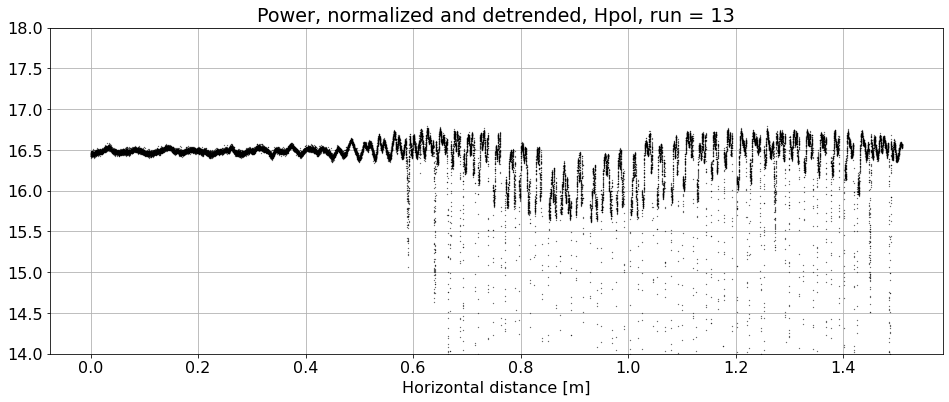

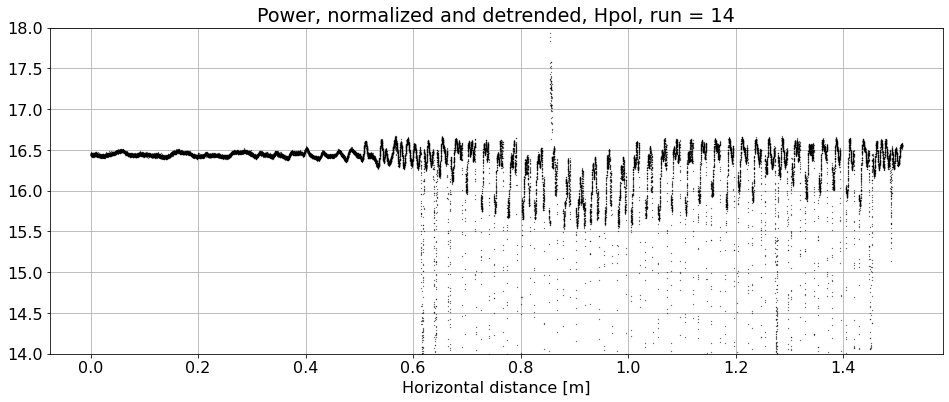

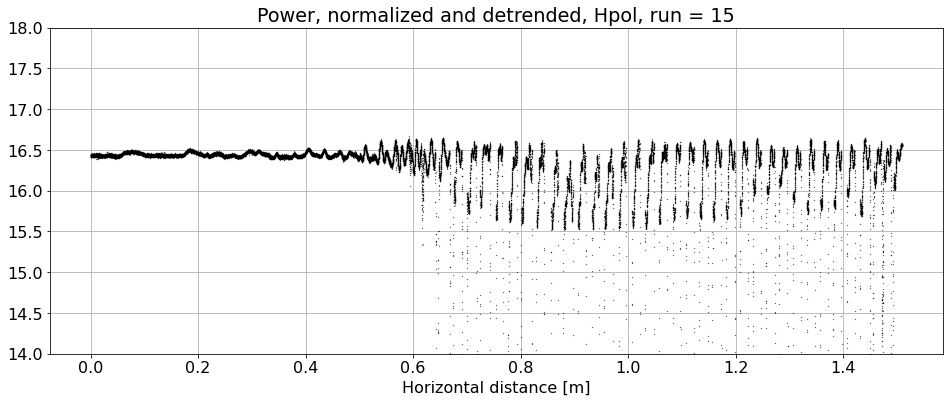

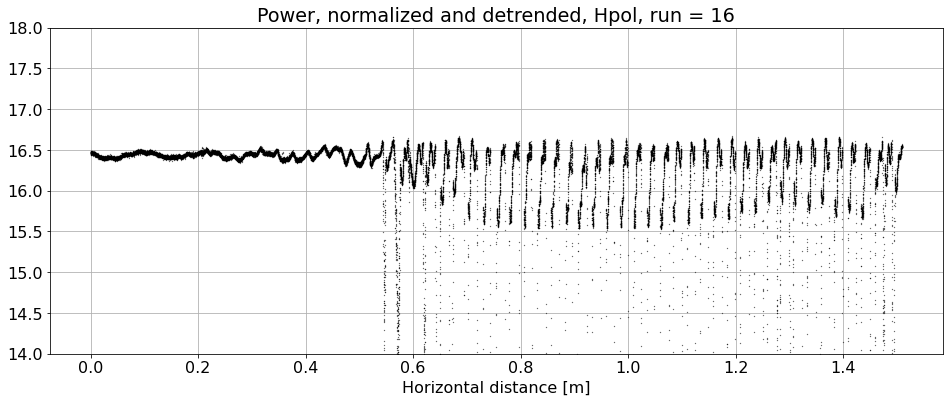

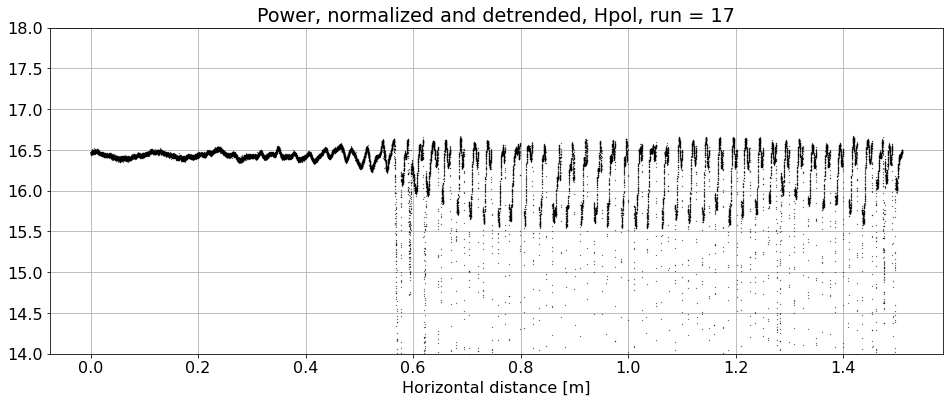

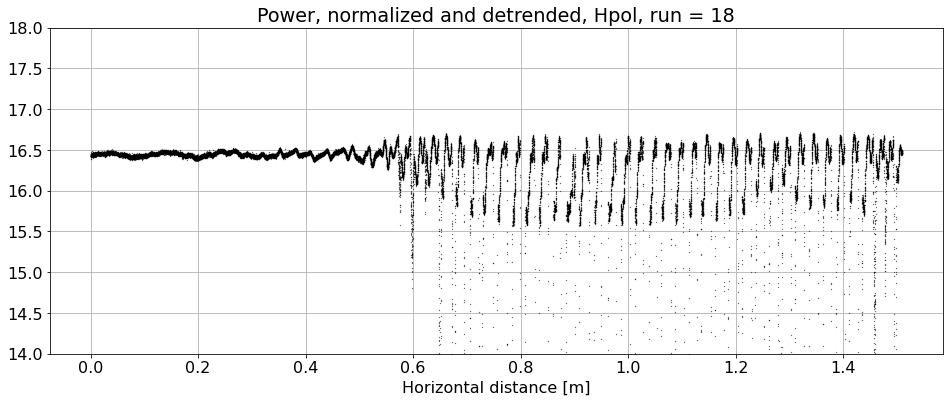

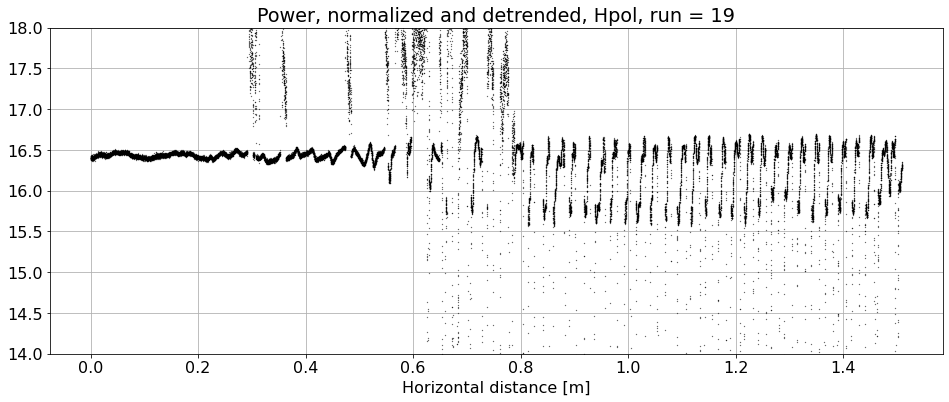

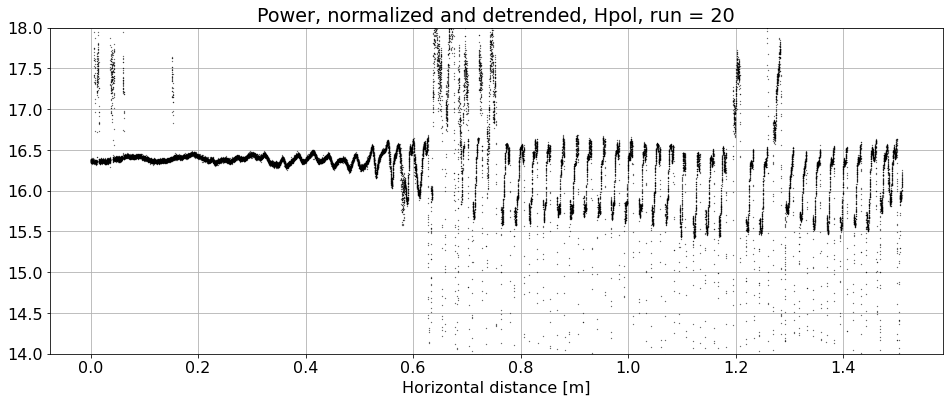

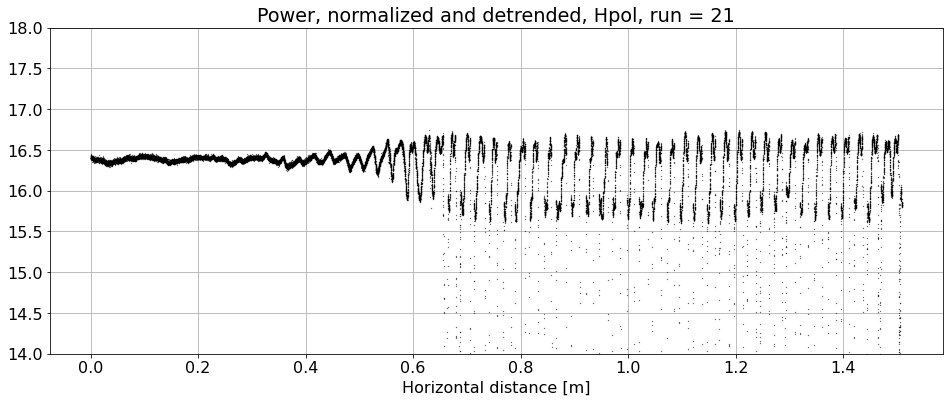

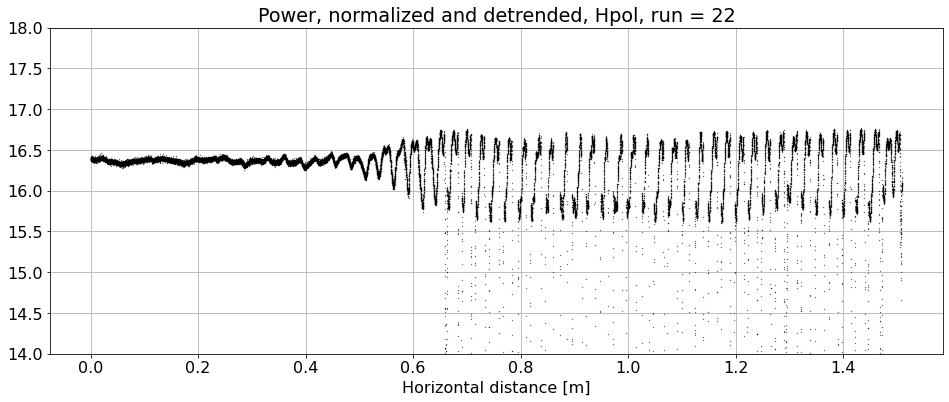

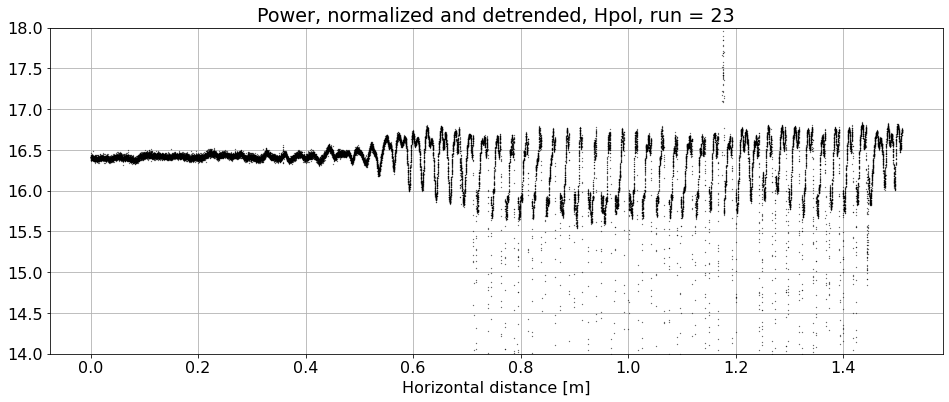

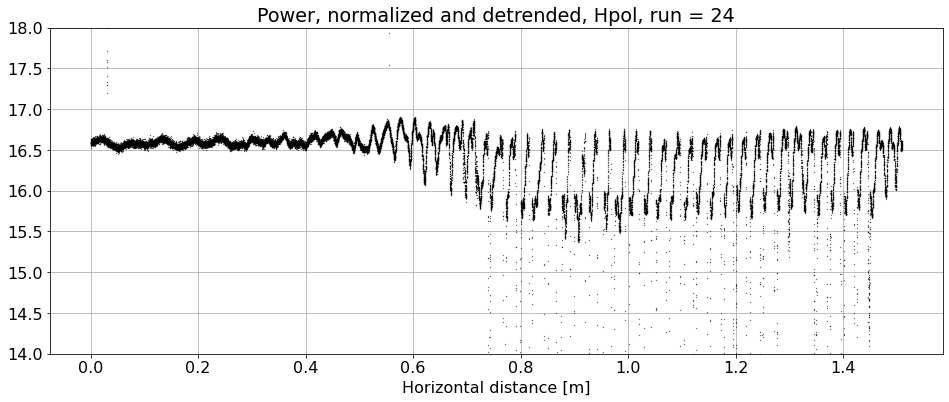

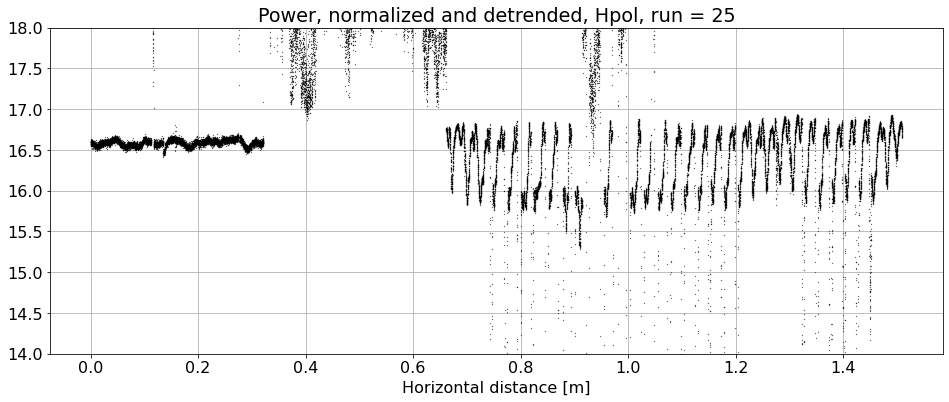

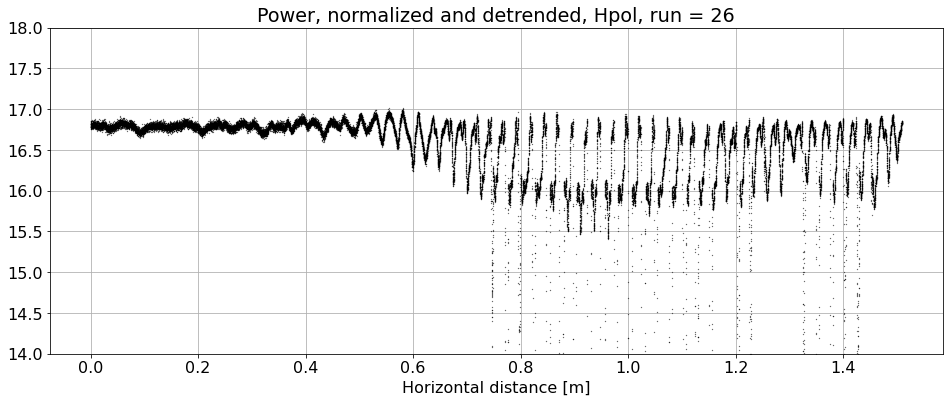

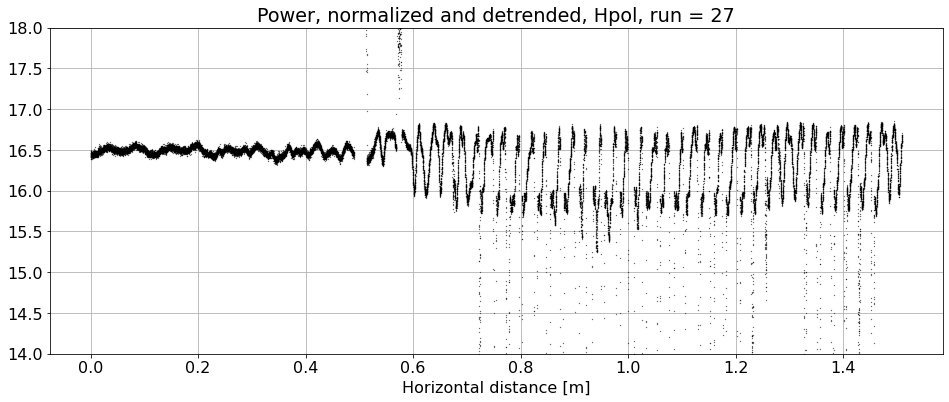

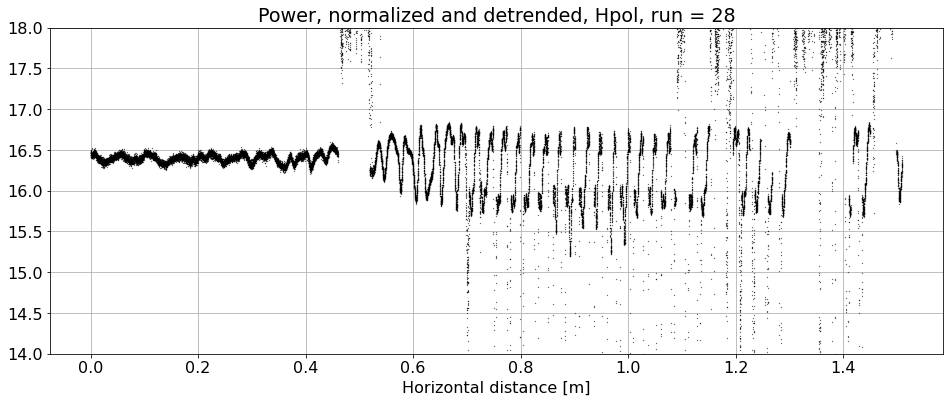

In [27]:
for i in whole_revolutions:
    mask = (revolutions >= i) & (revolutions <= i + 1)
    revolution_time = revolutions[mask] - revolutions[mask][0]
    x = 2 * revolution_time * calibration_length
    #base_power = np.mean(rho_h_norm[mask][revolution_time < 0.1])
    plt.figure(figsize=(16, 6))
    plt.plot(x[:x.size//2], np.abs(rho_h_norm[mask])[:x.size//2], 'k.', ms=0.5)
    plt.title('Power, normalized and detrended, Hpol, run = %i' % (i + 1))
    plt.grid()
    plt.ylim(14, 18)
    plt.xlabel('Horizontal distance [m]')
    plt.show()

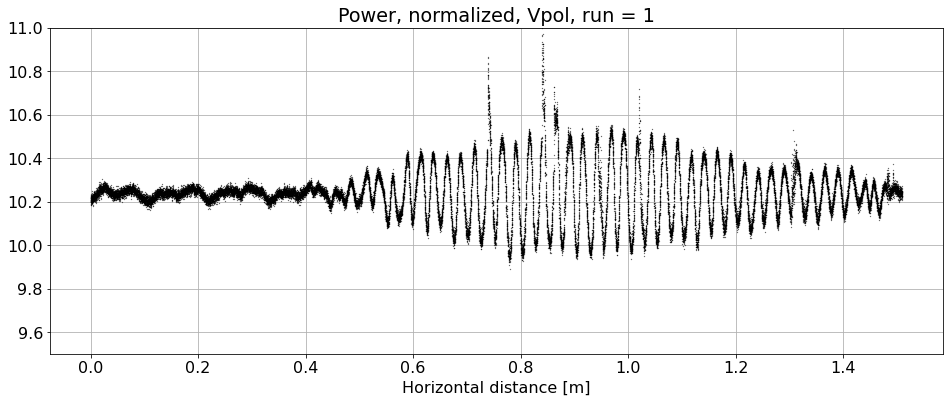

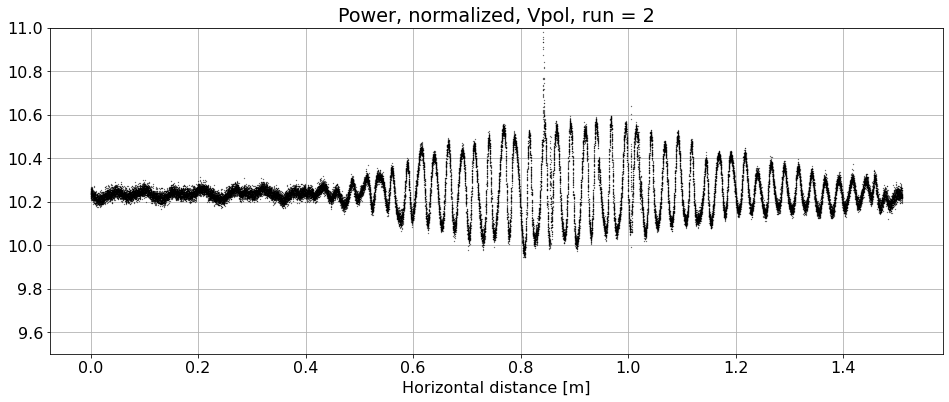

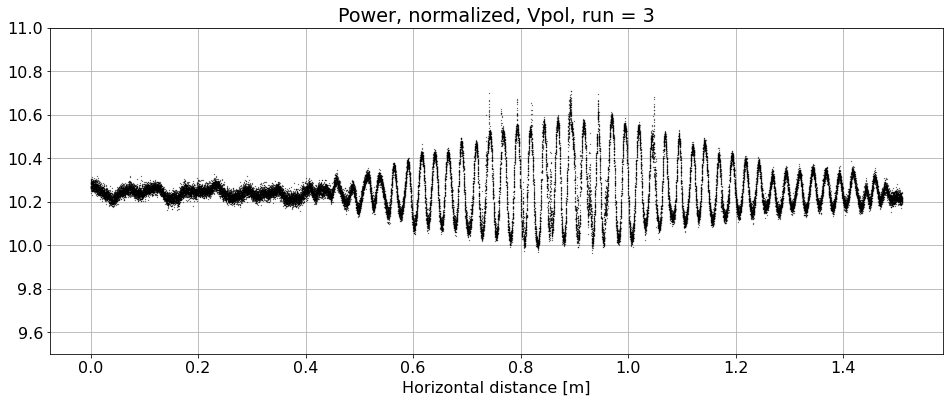

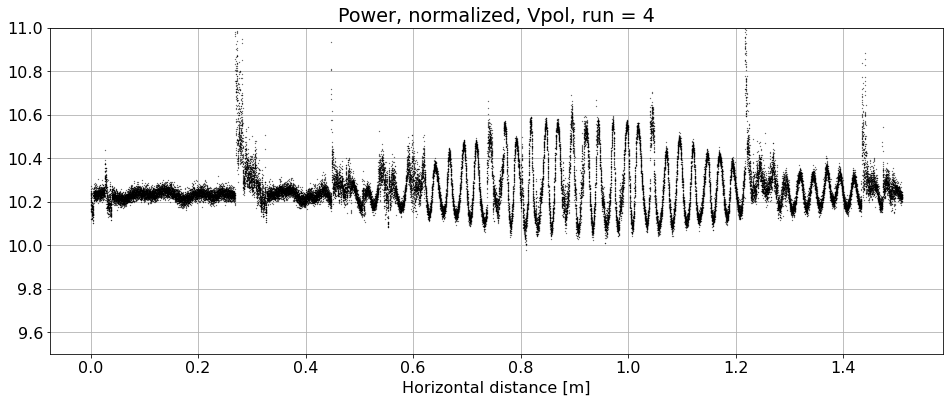

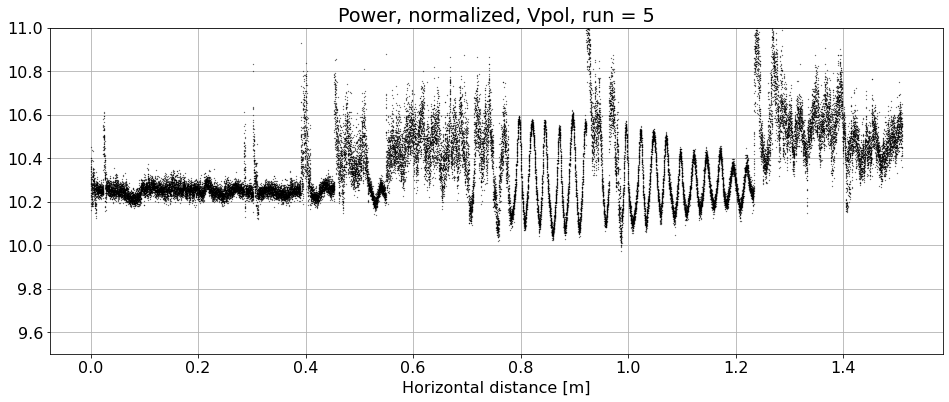

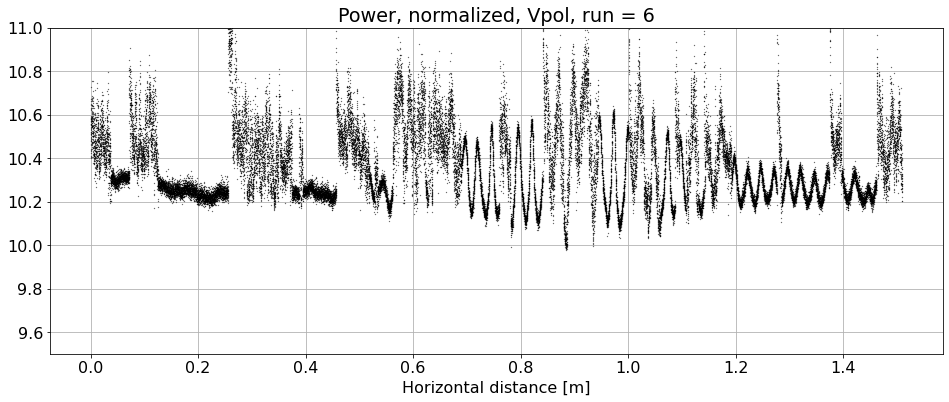

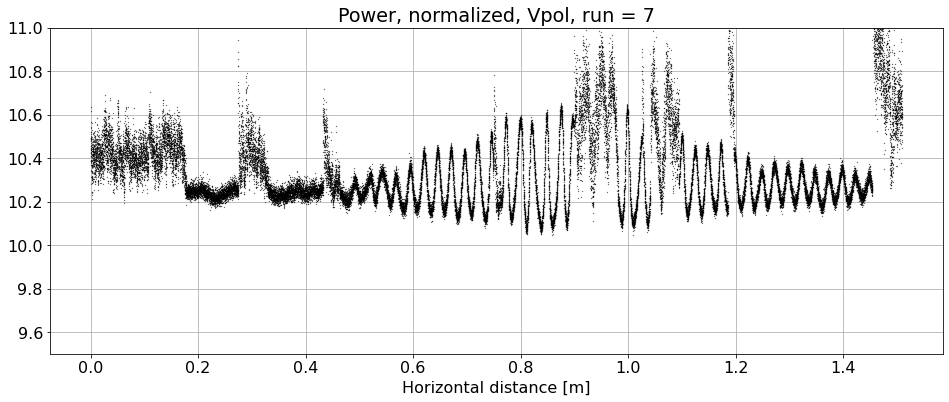

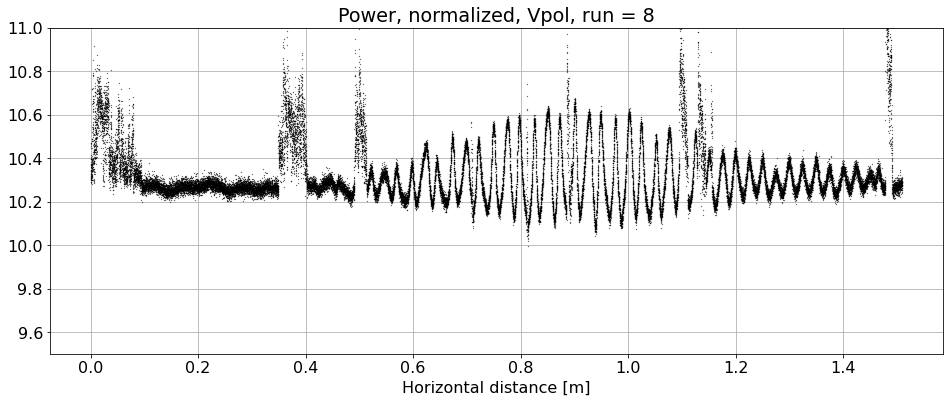

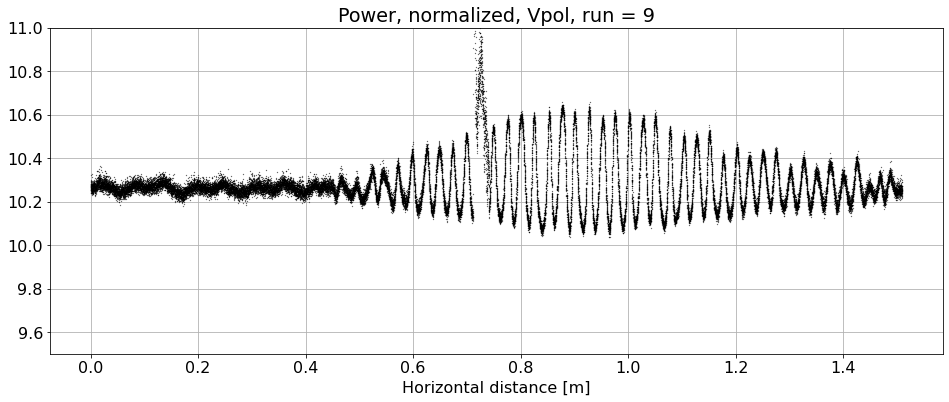

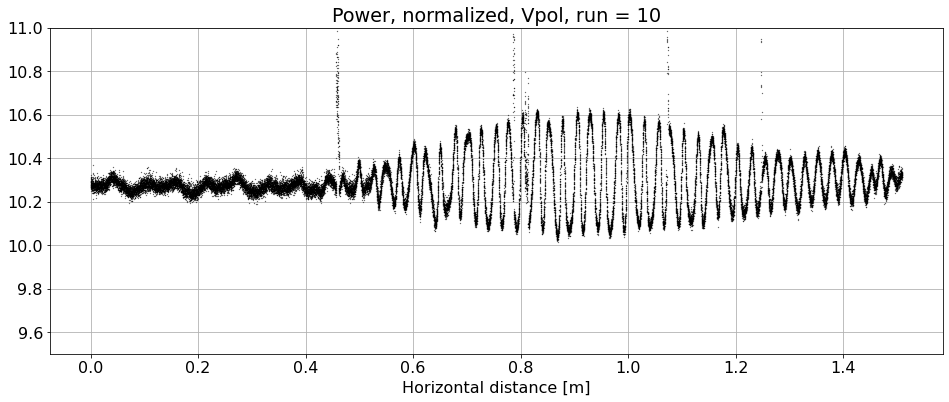

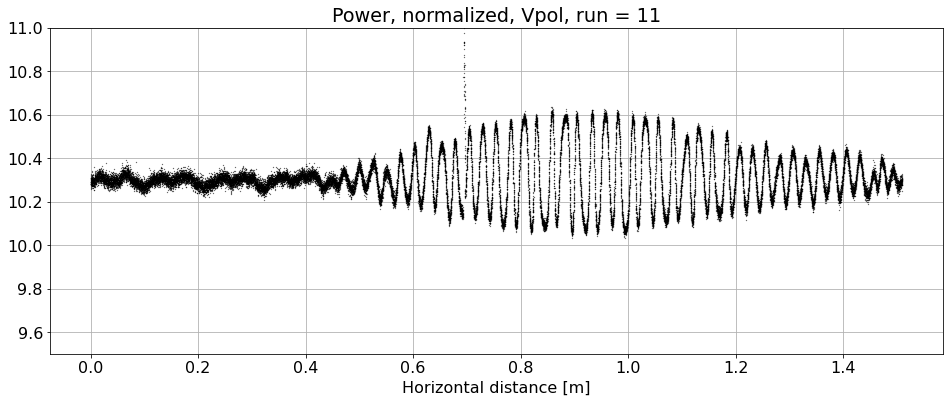

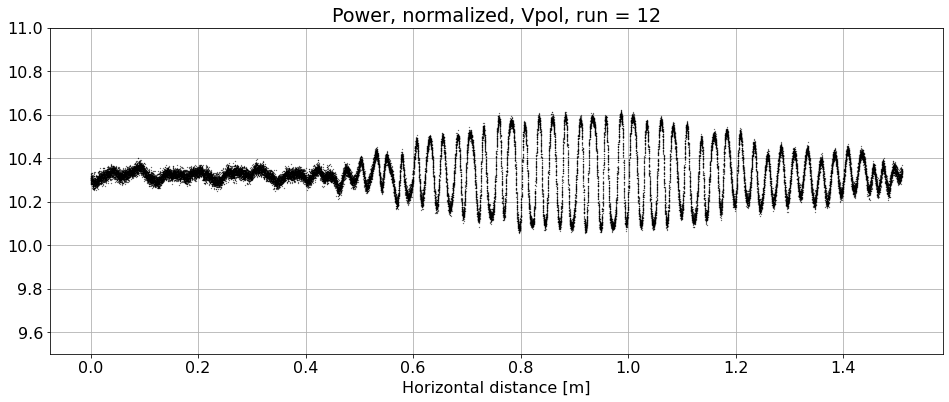

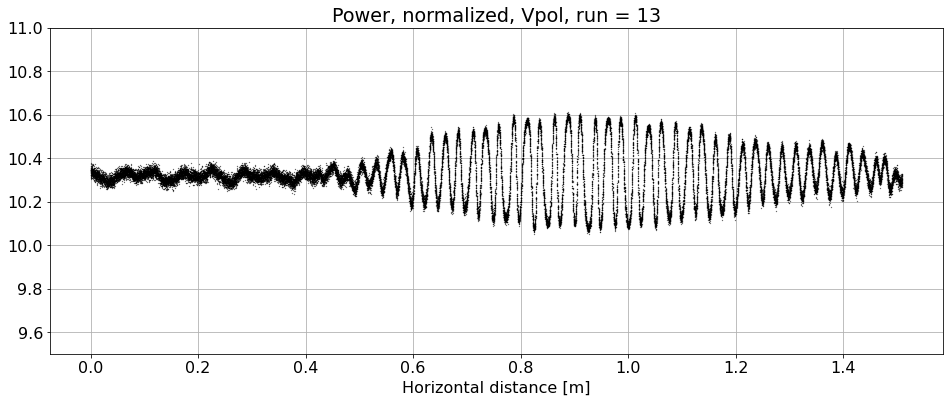

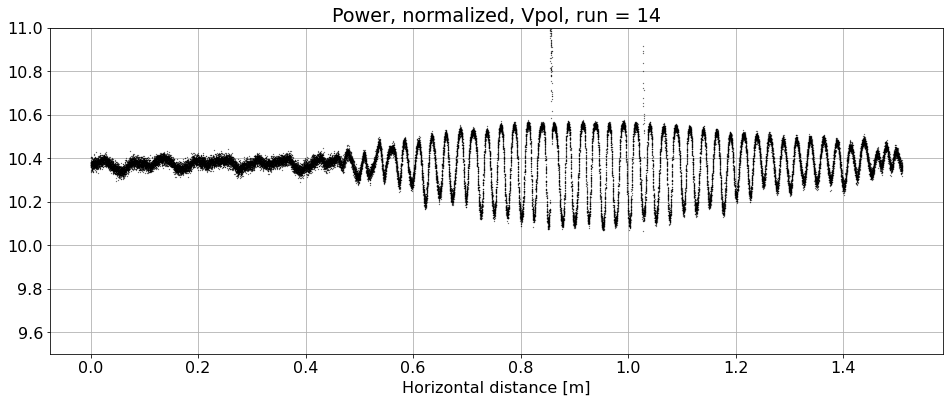

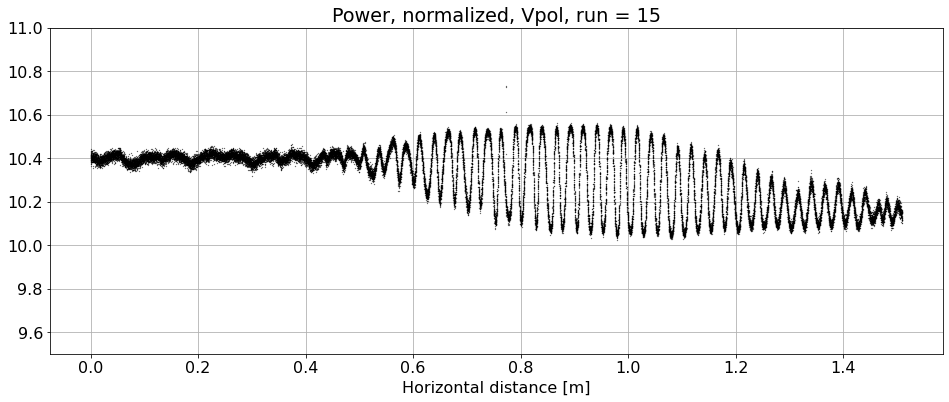

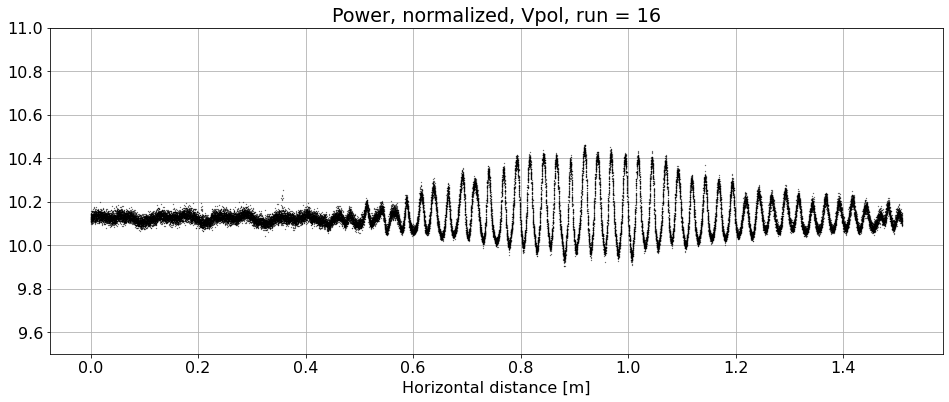

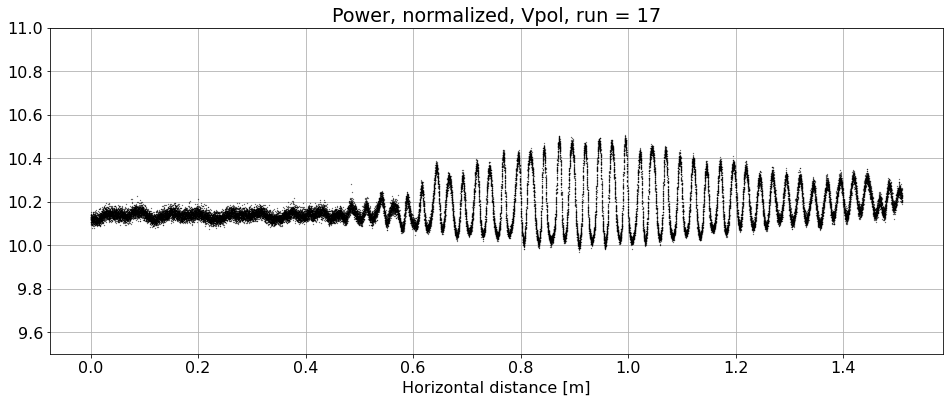

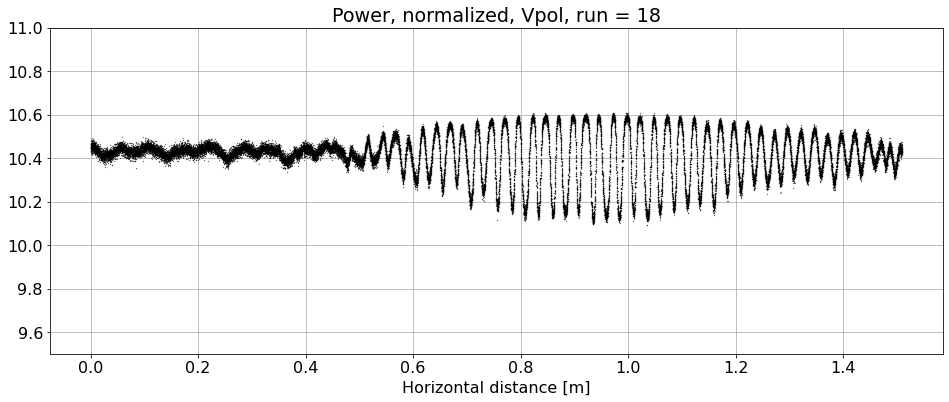

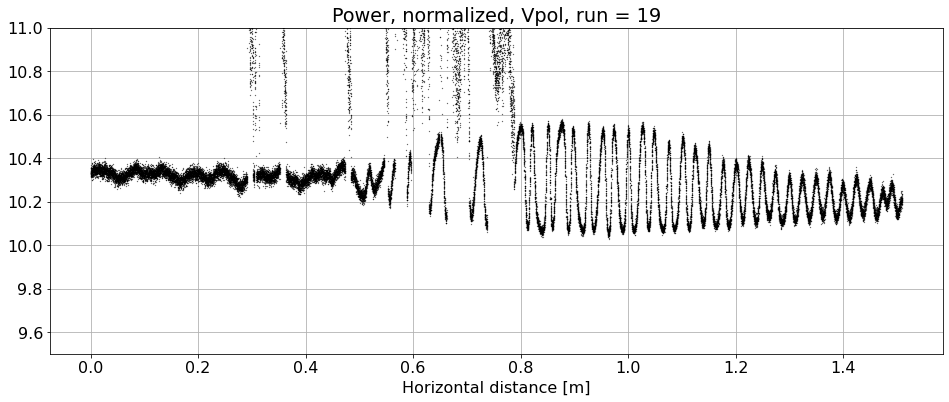

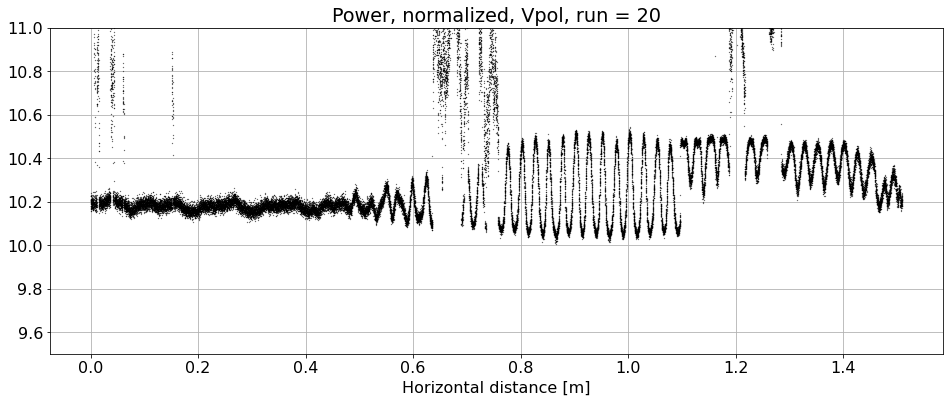

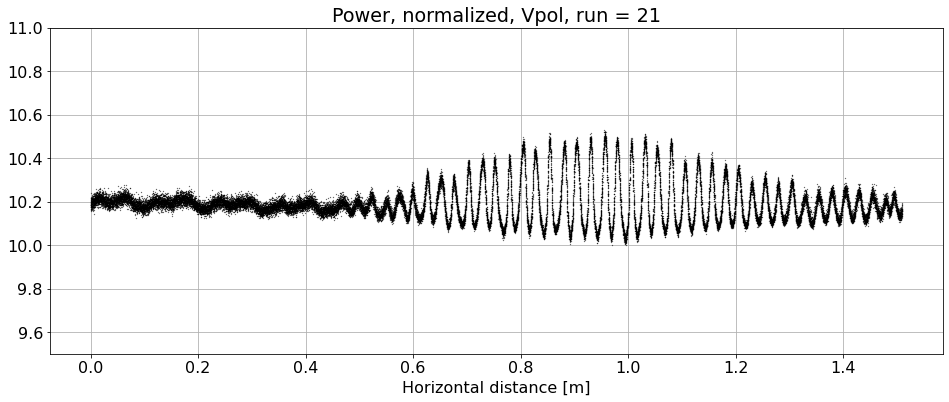

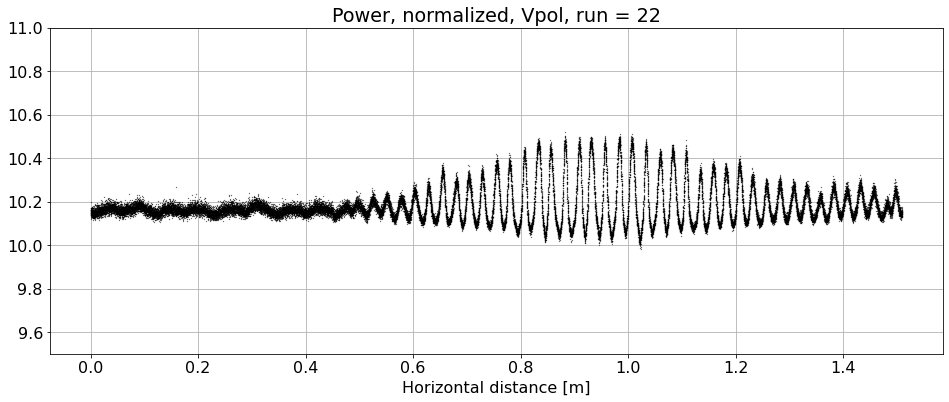

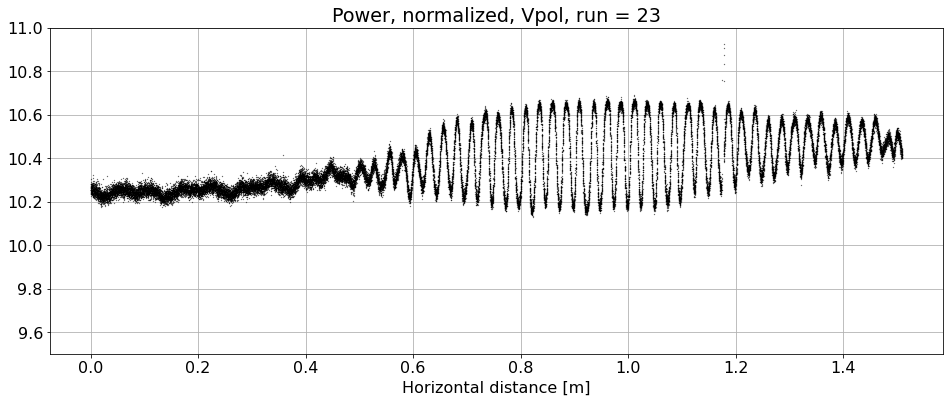

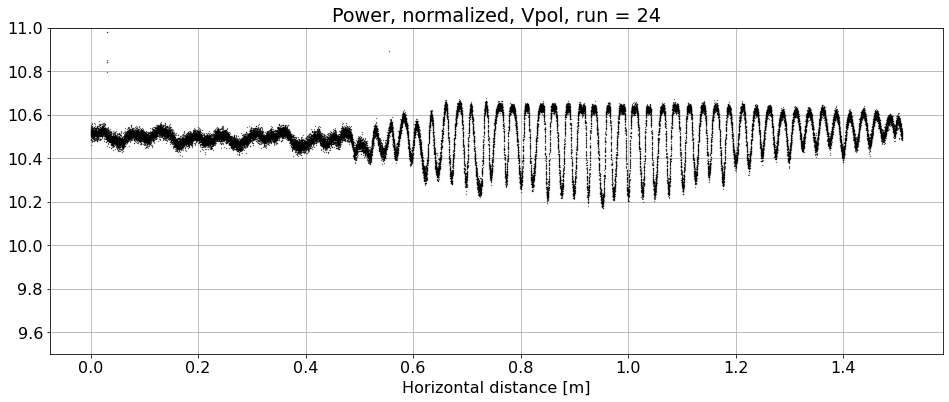

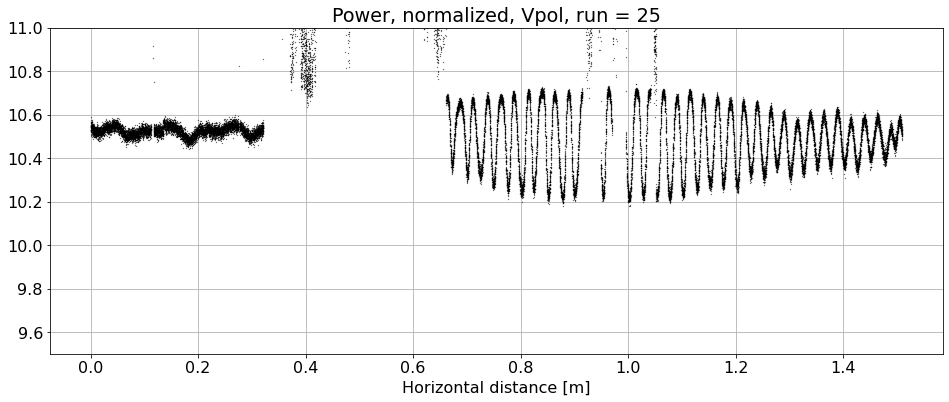

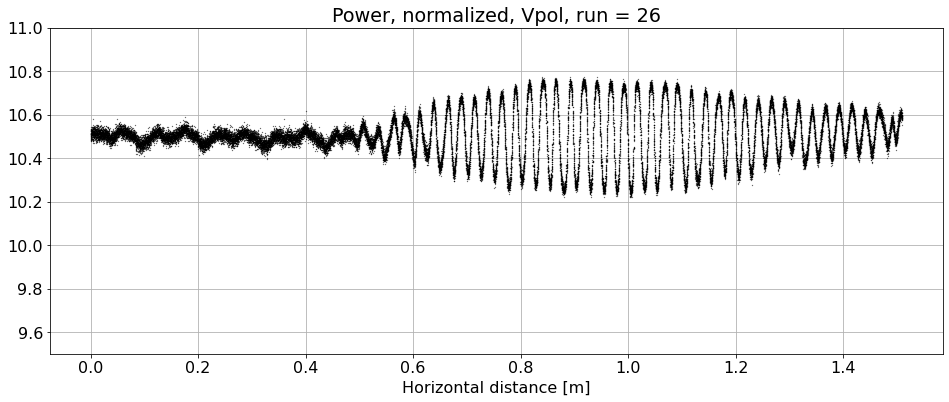

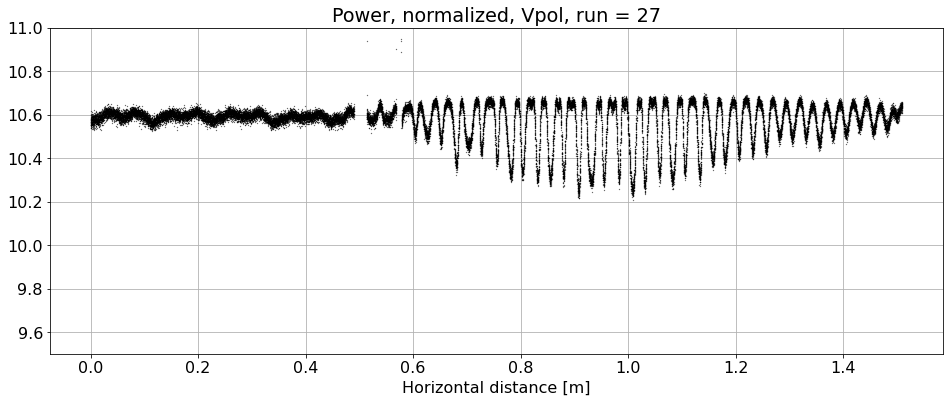

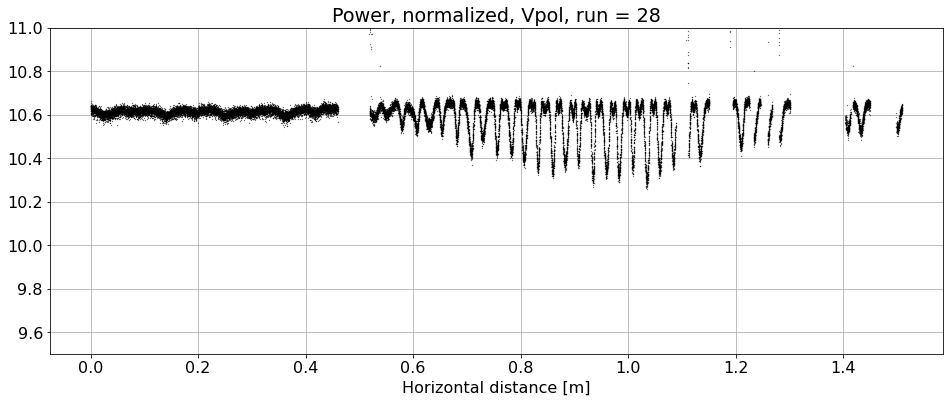

In [28]:
for i in whole_revolutions:
    mask = (revolutions >= i) & (revolutions <= i + 1)
    revolution_time = revolutions[mask] - revolutions[mask][0]
    x = 2 * revolution_time * calibration_length
    base_power = np.mean(rho_v_norm[mask][revolution_time < 0.1])
    plt.figure(figsize=(16, 6))
    plt.plot(x[:x.size//2], rho_v_norm[mask][:x.size//2], 'k.', ms=0.5)
    plt.title('Power, normalized, Vpol, run = %i' % (i + 1))
    plt.grid()
    plt.ylim(9.5, 11)
    plt.xlabel('Horizontal distance [m]')
    plt.show()

### Calibration constants

For each Hpol and Vpol, calculate

$$
C = \dfrac{\sigma_c}{\rho_c R_c^4}
$$

where:

* $C$ is the calibration constant
* $\sigma_c$ is the normalized radar cross-section of a conductive sphere from calibration (here, 2.946 based on the table from [Blake (1972)](https://apps.dtic.mil/sti/pdfs/AD0740746.pdf))
* $\rho_c$ is the maximum power recorded during the calibration
* $R_c$ is the range from the radar to the sphere, here approximately 1.805 m.

In [29]:
# Maximum power for Hpol and Vpol from calibration
Pmax_H = 17.0
Pmax_V = 10.7

In [30]:
# Calibration constants for Hpol and Vpol
C_H = sigma / Pmax_H / d**4
C_V = sigma / Pmax_V / d**4

In [31]:
C_H, C_V

(2.5245361120845994e-06, 4.010945224807307e-06)